# 12 機械学習の基礎（教師なし学習）

- **[12.1 クラスタリング](#12.1-クラスタリング)** 
<br><br>
- **[12.2 主成分分析](#12.2-主成分分析)** 
<br><br>
- **[12.3 マーケットバスケット分析とアソシエーションルール](#12.3-マーケットバスケット分析とアソシエーションルール)** 
<br><br>
- **[12.4 総合問題](#12.4-総合問題)**
    - [12.4.1 総合問題1](#12.4.1-総合問題1)

巻末参考URL : https://docs.google.com/spreadsheets/d/e/2PACX-1vRXG56iX93yr7gCO-9AStIhA8YXM4eoYoL_VPnT-SRTg7AFY_SL3uticBtQJvSMtIMXr_bwhqPeEZbh/pubhtml


***

## 12.1　教師なし学習
教師なし学習は、目的変数がない学習モデルです。より良いモデル構築のため教師あり学習と併用されたり、データに潜む構造やインサイト(示唆)発見のための探索的分析手法として活用されています。本章を通し、教師なし学習の多様な活用イメージと実行方法を理解しましょう。

### 12.1.1　教師なしモデルの種類
教師なしモデルには、主に次のようなものがあり、本章でその実装方法と使い方を学びます。

・クラスタリング

多数のデータをいくつかの類似グループに分類する手法です。具体的には、マーケティングのアプローチで、顧客のセグメンテーション（顧客を分類すること）やターゲティング（対象を絞り込む方法）するときなどに使います。

・主成分分析

変数が多い場合に使う次元圧縮の手法です。それらの変数の情報をなるべく減らさずに、変数の数を減らしたい場合に使います。


・マーケットバスケット分析（アソシエーションルール）

スーパーマーケットやコンビニ、ウェブサイトでの買い物の分析によく使われて、商品を買うときの組み合わせで、どれが多いかなど分析をします。


### 11.1.2　この章で使うライブラリ

この章では、機械学習のsklearnをはじめ、第10章で用いたのと同じライブラリを使います。このようにインポートすることを前提として進めていきます。

In [2]:
# 途中で使用するため、あらかじめ読み込んでおいてください。
# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習ライブラリ
import sklearn

# 小数第３まで表示
%precision 3

'%.3f'

## 12.2 クラスタリング
キーワード：クラスタリング、k-means、k-means++、エルボー法、シルエット係数、非階層型クラスタリング、階層型クラスタリング、ハードクラスタリング、ソフトクラスタリング

本節ではまず、教師なし学習の一つであるクラスタリングについて学びます。クラスタリングが扱うデータは、教師あり学習とは異なり目的変数を含みません。つまり、クラスタリングは目的変数と説明変数の関係性を表現しようとするモデリング技術ではなく、データそのものに着目しそこに隠れた構造やインサイトを見つけ出すためのモデリング技術と位置付けられます。そのためクラスタリングは、分析者自身が取り扱うデータの特徴を把握するため、探索的分析の第一歩として初期分析の一つとして採用されることがあります。

### 12.2.1　クラスタリングの目的
クラスタリングの目的は、与えられたデータを類似性の高いグループに分けることです。クラスターとは「集団」や「群れ」という意味です。例えば車体形状などを持った自動車のデータ群をクラスタリングすると、軽自動車とトラックはその車体形状が違うので、異なる特徴を持った別々のクラスターに分割されるといったイメージです。クラスタリングで最も広く使われている手法は**k-means**法と呼ばれるものです。以下の図は、ある属性データ（収入、借入）をk-means法でクラスタリングした結果、顧客が3つのグループに分かれたところを示したものです。人間には自明に思えるこのようなデータのグループ化を、k-means法では以下の手順で実現しようとします。

- step1. 平面の中にランダムに3つの点をプロットする。
- step2. 各ランダム点を、クラスター1、クラスター2、クラスター3の重心点とラベリングする。
- step3. 入力データの各点について、3つの重心点の中で最も近いものを選び、それを自身の所属クラスター番号とする。
- step4. すべての入力データについてクラスター番号が決まった後、それぞれのクラスターの重心（平均）を計算する。
- step5. step4で求まった3つの点を新しいクラスターの重心点とする。
- step6. step3からstep5を繰り返す。ただし、繰り返し上限回数に達する、または重心の移動距離が十分に小さくなったら終了とする。

![comment](http://insidebigdata.com/wp-content/uploads/2013/12/Clustering.gif)

Scikit-learnでk-meansを実行するには、`sklearn.cluster`モジュールの`KMeans`クラスを使います。`KMeans`クラスの初期化パラメータ（init='random'）を省略すると**k-means++**になります。k-means++は、k-meansで初期値で設定する値をなるべく広げて取るように計算する手法で、k-meansよりも安定的な結果が得られます。k-meansは先述の通り、ランダムに初期の重心点を配置するので、その影響で初期位置に偏りが生じる可能性があり、その解決を試みたのがk-means++ということです。他にも重心を平均（centroid）でなく、中央値（medoid）とする**k-medoids法**があります。これは重心位置が架空の数値をとる可能性を防げます。また外れ値による影響が少ないこともこの方法のメリットです。

>**[やってみよう]**

>k-means、k-means++、k-medoidsについて調べてみましょう。それぞれのメリット、デメリットや実行方法など調べてみましょう。

### 12.2.2　k-means法でクラスタリングする

ここでは、Scikit-learnを用いた（純粋な）k-means法でクラスタリングしてみます。

#### 学習データの作成
学習データは`sklearn.datasets`モジュールの`make_blobs`関数を使って作成するものとします。`make_blobs`関数は縦軸と横軸に各々標準偏差1.0の正規分布に従う乱数を生成する関数で、主にクラスタリング用のサンプルデータ生成に使われます。以下の例ではrandom_stateとして10を指定しています。これは乱数ジェネレータのシードです。make_blobs関数には、とくに引数を与えなければ、0から10の範囲の乱数を100個生成します。下記は生成した乱数をMatplotlibを使ってグラフ化したものです。

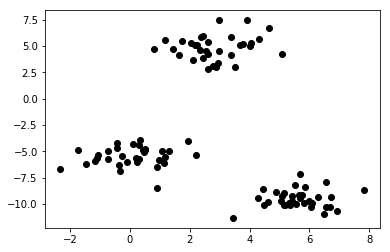

In [5]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# random_state=10にするのは、説明のためにうまくプロットをばらすためです。
X, y = make_blobs(random_state=10)
plt.scatter(X[:,0],X[:,1],color='black')

#### KMeansオブジェクトを使ったクラスタリング

k-meansモデルを使って学習し、クラスタリングした結果のそれぞれにクラスター番号と呼ばれる連番を付けるプログラムは、次のようになります。クラスター番号は0から始まる番号として付けます。

まず、`KMeans`オブジェクトを初期化します。パラメータはinit='random'、n_clusters=3と設定しています。initは設定する初期値です。このように'random'を設定するとk-means++ではなくk-means法となります。n_clustersはクラスター数です。

KMeansオブジェクトを作ったらfitメソッドを実行します。するとクラスターの重心が計算され、`predict`メソッドを実行することでクラスター番号が予測されます。fitとpredictを一連の処理として実行する`fit_predict`メソッドもありますが、基本的に構築したモデルを保存する可能性のある場合は、`fit`メソッドを単独で実施するのがよいでしょう。

In [3]:
kmeans = KMeans(init='random',n_clusters=3)
kmeans.fit(X)
y_pred = kmeans.predict(X)

#### 結果の確認

k-meansの学習結果をグラフ化し確認してみましょう。グラフ化には第6章で学んだPandasのテクニックを使います。グラフ化は、クラスター番号ごとにデータを取り出し、色を指定して図示しています。k-means法によって、私たちが期待する通りの3つのグループにデータを分けられていることが確認できます。

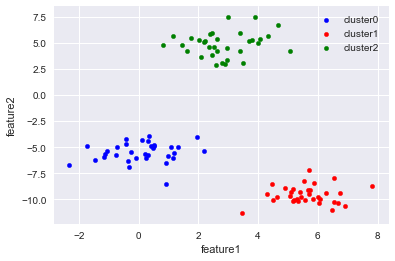

In [4]:
# 順にx座標、y座標、クラスター番号のデータを横に結合するためaxis=1と指定
merge_data = pd.concat([pd.DataFrame(X[:,0]), pd.DataFrame(X[:,1]), pd.DataFrame(y_pred)], axis=1)

# X軸をfeature1、Y軸をfeature2、クラスター番号をclusterと列名指定
merge_data.columns = ['feature1','feature2','cluster']

# クラスタリング結果のグラフ化
ax = None
colors = ['blue', 'red', 'green']
for i, data in merge_data.groupby('cluster'):
    ax = data.plot.scatter(x='feature1', y='feature2', color=colors[i],
                                           label=f'cluster{i}', ax=ax)
    plt.grid(True)

### 12.2.3　金融マーケティングデータをクラスタリングする
さてここからは、クラスタリング結果の活用イメージを深めるため、金融マーケティングデータを使ってクラスタリングを実行し、その結果を詳しくみていきましょう。

#### 分析要求
データはある金融機関のデータで、お客さまが定期預金の申し込みをしたか否かの変数を含んでいます。その他の変数にはキャンペーンの実施状況、お客さまの属性情報などの情報が含まれています。このデータをクライアントから受け取り、「そもそも私たちにどのようなお客さまがいるのかわからないので分析してほしい」という分析要求を提示されたと仮定しましょう。

教師あり学習のアプローチで考えるならば、定期預金をしたか否かを目的変数にしてモデルを構築したいところですが、分析要求は必ずしも目的変数を特定したものではありません。データ分析の現場では目的変数が定まらないということは珍しくなく、分析者自身がデータ理解を深めるための第一歩として教師なし学習（クラスタリング）を採用することがあります。

#### 分析対象データの読み込み
ここで対象とするデータは下記のURLで配布されている学習用のデータで、それに含まれるbank-full.csvファイルとします。

http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

まずはこのデータをダウンロードして展開します。

In [5]:
# webからデータを取得したり、zipファイルを扱うためのモジュール
import requests, zipfile
import io

# データがあるurl の指定
zip_file_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'

# データを取得して展開する
r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

対象データは`bank-full.csv`のため、それを読み込みます。区切り記号は`seq`パラメータで設定しています。先頭から5行をhead()で表示すると次のようになります。

In [6]:
bank= pd.read_csv("bank-full.csv", sep=";")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


データの意味は、zipファイルに含まれているbank-names.txtに記載されています。以下に、その一部を抜粋します。inputが説明変数、outputが目的変数ですが、ここでは目的変数を予測するかどうかは意識しないでおきましょう。`age`などの連続変数の他に、`job`や`education`といったカテゴリ変数が存在していることがわかります。

-Input variables:
- ##### bank client data:
1 - age (numeric)  
2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")  
3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
4 - education (categorical: "unknown","secondary","primary","tertiary")  
5 - default: has credit in default? (binary: "yes","no")  
6 - balance: average yearly balance, in euros (numeric)    
7 - housing: has housing loan? (binary: "yes","no")  
8 - loan: has personal loan? (binary: "yes","no")   
- ##### related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
10 - day: last contact day of the month (numeric)  
11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
12 - duration: last contact duration, in seconds (numeric)  
- ##### other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
15 - previous: number of contacts performed before this campaign and for this client (numeric)  
16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")  

-Output variable:
- ##### desired target
17 - y - has the client subscribed a term deposit? (binary: "yes","no")

#### データの整理と標準化
データのレコード数や変数の数、欠損データを確認しておきましょう。下記のプログラムを実行することで、データは45211レコードの17変数とわかります。カテゴリ変数はありましたが、欠損データはないことがわかります。

In [7]:
print('データ次元数(X,y):{}'.format(bank.shape))
print('欠損データの数:{}'.format(bank.isnull().sum().sum()))

データ次元数(X,y):(45211, 17)
欠損データの数:0


ここでは話を簡単にするため、分析対象の変数をage、balance、campaign、previousに限定することにします。これらの変数は、それぞれ単位が異なるので、教師あり学習でも行った標準化を前処理として行います。こうすることで値の大きな変数にクラスタリングの学習が引っ張られずに済みます。

In [8]:
from sklearn.preprocessing import StandardScaler

bank_sub = bank[['age','balance','campaign','previous']]
sc = StandardScaler()
sc.fit(bank_sub)
bank_sub_std = sc.transform(bank_sub)

#### クラスタリング処理
データを標準化したら、k-meansでクラスタリング処理を実行します。ここではクラスター数を6としました。クラスタリング処理を終えたら、`kmeans`オブジェクトの`labels_`属性から、各データの所属クラスター番号を配列で取得できます。以下のプログラムでは`pandas`の`Series`オブジェクトに変換してクラスター別データ件数を集計し、クラスター構成を棒グラフで表示しています。

0    24509
1      221
2     2684
3     1380
4    14734
5     1683
Name: cluster_number, dtype: int64


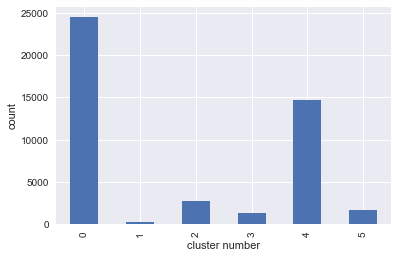

In [9]:
kmeans = KMeans(init='random', n_clusters=6, random_state=0)
kmeans.fit(bank_sub_std)

labels = pd.Series(kmeans.labels_, name='cluster_number')
print(labels.value_counts(sort=False))

ax = labels.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel('cluster number')
ax.set_ylabel('count')
plt.grid(True)

### 12.2.4　エルボー法によるクラスター数の推定
ここではクラスター数を6と決め打ちしましたが、クラスター数を事前に見積もる方法として**エルボー法**があります。エルボー法はクラスターの重心点とクラスター所属の各点の距離の総和に着目します。クラスター数が1つから適切な数まで増える過程では、各点がより近いクラスター重心に所属できるようになるので、この総和は相応に減少することが期待できます。一報、一旦適切な数を超えて、さらにクラスター数が増える過程では、この総和の減少度合いが低下すると予想されます。このように、クラスター数の増加に伴う重心点と各点の距離の総和の減少度合いの変わり目に着目して、適切なクラスタ数を決めようと判断しようとするのがエルボー法です。

まずは、`make_blobs`関数で生成したデータXに対してエルボー法を試します。距離の総和は`KMeans`オブジェクトの`inertia_`属性で取得できます。クラスタ数1から10までの距離の総和を求めてグラフにしたのが、次の図です。結果を見るとわかるように、クラスター数が3を超えると、縦軸の減少幅が急速に低下しています。ですから、適切なクラスター数は3であると推定できます。このように距離の総和を見ると、理想的なクラスター数を境に縦軸低下の傾きが変化します。この形状がエルボーのように見えることからエルボー法と名付けられました。

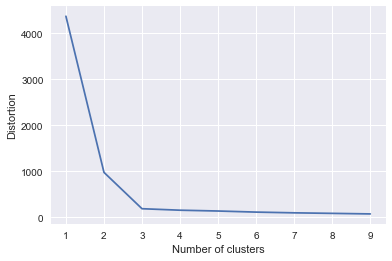

In [10]:
dist_list =[]
for i in range(1,10):
    kmeans= KMeans(n_clusters=i, init='random', random_state=0)
    kmeans.fit(X)
    dist_list.append(kmeans.inertia_)
    
plt.plot(range(1,10), dist_list,marker='+')
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")
plt.grid(True)

エルボー法の仕組みが分かったところで、金融期間のマーケティングデータに対してもエルボー法を試してみましょう。ここではクラスター数1から20までの距離の総和をグラフにしてみました。

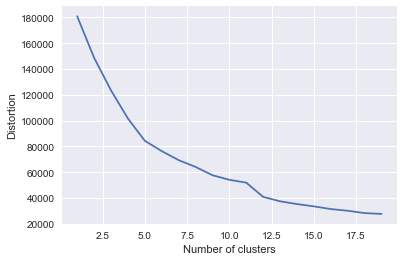

In [11]:
dist_list =[]
for i in range(1,20):
    kmeans= KMeans(n_clusters=i, init='random', random_state=0)
    kmeans.fit(bank_sub_std)
    dist_list.append(kmeans.inertia_)
    
plt.plot(range(1,20), dist_list,marker='+')
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")
plt.grid(True)

先の`make_blobs`関数の結果に対して実施したほど明らかではありませんが、クラスター数が5〜6付近で減少幅がやや低下していることがわかります。もしエルボー法で傾向が見られない場合は、**シルエット係数**など、その他のクラスター数判断のための方法を試す、分析領域の固有知識に基づき決定する、またはデータの概要把握と割り切り解釈可能な範囲のクラスター数で処理を進めるなどしましょう。

### 12.2.5　クラスタリング結果の解釈
k-means法によるクラスタリングの実行方法は以上です。ここからはクラスタリングの処理結果を利用したデータの解釈を試みたいと思います。まず金融マーケティングデータの元データに対して、先程得たクラスタリング結果を紐付けます。データの一番右にcluster_numberという変数を付けました。これが分類されたクラスターの番号となります。

In [12]:
bank_with_cluster = pd.concat([bank, labels], axis=1)
bank_with_cluster.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster_number
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,4
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,4
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,4
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0


次に、クラスター別の年齢層を確認してみます。それには第6章で学んだピボットテーブルを使います。軸はクラスター番号（cluster_number）と年齢（age）です。年齢は15歳から5歳区切りを基本に、最後は65歳以上100歳未満で区切ってみます。

In [13]:
bins = [15,20,25,30,35,40,45,50,55,60,65,100]
qcut_age = pd.cut(bank_with_cluster.age, bins, right=False)
hist_age = pd.value_counts(qcut_age)

df = pd.concat([bank_with_cluster.cluster_number, qcut_age], axis=1)
cross_cluster_age = df.groupby(['cluster_number', 'age']).size().unstack().fillna(0)
cross_cluster_age

age,"[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 65)","[65, 100)"
cluster_number,,,,,,,,,,,
0,45.0,711.0,4024.0,8492.0,7146.0,4091.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,10.0,37.0,25.0,26.0,27.0,30.0,38.0,11.0,14.0
2,0.0,14.0,152.0,497.0,517.0,460.0,375.0,306.0,263.0,63.0,37.0
3,0.0,20.0,132.0,327.0,308.0,187.0,146.0,117.0,71.0,38.0,34.0
4,0.0,0.0,0.0,0.0,0.0,1155.0,4701.0,3885.0,3436.0,838.0,719.0
5,2.0,14.0,146.0,387.0,353.0,266.0,221.0,150.0,114.0,24.0,6.0


数値だけではわかりにくいので、クラスター内の年齢層割合を計算してグラフ化してみましょう。このような場面では、割合が多いほど濃くなるヒートマップを使ってグラフ化すると便利です。下のヒートマップから、クラスター番号0では年齢層が30-40歳の割合が高い一方、クラスター番号4は45-60歳の割合が高くなっていることなどが確認できます。この結果から、この2つのクラスターは年齢に偏りを持ったクラスターと言えそうです。

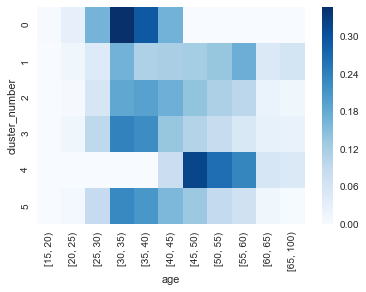

In [14]:
sns.heatmap(cross_cluster_age.apply(lambda x : x/x.sum(), axis=1), cmap='Blues')

同様に、職業を示す変数jobについても見てみましょう。jobはageと異なりカテゴリ変数です。そこでそのまま集計してグラフ化します。下のヒートマップから、クラスター番号1では特にマネジメント層の割合が高いこと、クラスタ番号0ではブルーカラー割合がやや高いことがわかります。

In [15]:
cross_cluster_job = bank_with_cluster.groupby(['cluster_number', 'job']).size().unstack().fillna(0)
cross_cluster_job

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
cluster_number,,,,,,,,,,,,
0,3097,5610,728,426,5130,57,852,2564,813,4459,698,75
1,15,12,19,7,91,24,11,9,3,21,6,3
2,219,459,91,70,788,111,130,189,48,460,99,20
3,196,244,42,22,332,53,41,112,52,250,31,5
4,1467,3040,543,675,2732,1984,479,1124,4,2084,439,163
5,177,367,64,40,385,35,66,156,18,323,30,22


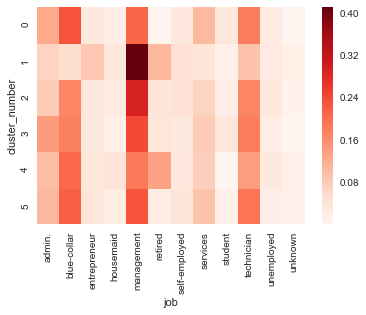

In [16]:
sns.heatmap(cross_cluster_job.apply(lambda x : x/x.sum(), axis=1),cmap='Reds')

これまでの結果から、クラスター番号0は年齢層は30〜40歳割合が高く、ブルーカラーの人がやや多いグループなどと解釈できそうです。実務においては、より多くの次元を調査することになるでしょう。ただし、無闇に集計と可視化を繰り返すのではなく、分析の結果からどのようなアクションを計画しているかなども考慮し分析計画を練ると良いでしょう。以上簡単ではありますが、クラスタリング結果に解釈を与える流れの紹介を終えます。

### 12.2.6　k-means法以外の手法

最後に、クラスタリング手法の体系化について補足します。本章で学んだk-means法は**非階層型**といわれるクラスタリング手法に属していますが、それとは別に**階層型**のクラスタリング(hierarchical clustering)に属する手法があります。Scikit-learnでは`sklearn.cluster`モジュールの`AgglomerativeClustering`クラスで実行できます。系統樹図（デンドログラム：dendrogram）といった用語と合わせて調べるとよいでしょう。また、クラスタリング手法の他の分け方に**ソフトクラスタリング**があります。k-means法は**ハードクラスタリング**に分類され、それぞれのデータに対してクラスター番号は一意に決まりましたが、ソフトクラスタリングでは各クラスターへの所属確率が計算できます。例えば、顧客の趣味嗜好のクラスタリングは、ハードクラスタリングよりもソフトクラスタリングの方が理に適っているかもしれません。目的により使い分けましょう。ソフトクラスタリングは、`sklearn.mixture`モジュールの`GaussianMixture`クラスなどで実行できます。

>**[やってみよう]**

>上の階層型、非階層型のクラスタリングについて調べてみましょう。また、ソフトクラスタリングやハードクラスタリングの違いやそのアプローチについて調べて、代表的な手法の実行方法を確認しましょう。
>> 参考：scikit-learn/examples/cluster/plot_hierarchical_clustering_dendrogram.py

####  <練習問題 1>
`sklearn.datasets`モジュールの`make_blobs`関数を使い、random_state=52（特に数字に意味はありません）にしてデータを生成しグラフ化してみましょう。そこからクラスター分析をしてください。いくつのグループに分けますか。また分けた後は、クラスター番号がわかるように色分けして、グラフ化してください。

####  <練習問題 2>
先ほど扱ったデータ`bank_sub_std`に対して、クラスター数を4にしてk-meansを実行した場合、どのような結果になるでしょうか。先程同様に、クラスター番号を取得した後、それぞれのクラスターについての分析して特徴を読み取りましょう。またクラスター数を8にした場合はどうでしょうか。更に、age、balance、campaign、previous以外の変数を選んだ場合はどうでしょうか。

## 12.3 主成分分析
キーワード： PCA、固有値、固有ベクトル、次元削減

本節では、主成分分析（principle component analysis）について学びます。これまで見てきた通り、データには多数の変数があります。先ほどの金融マーケティングデータにも職業や年齢など様々な変数がありました。説明変数と目的変数との関係性を1つ1つ見ていくことも大切ですが、説明変数の数が増えれば、その理解にも限界があります。主成分分析は、元データのもつ情報をできるだけ失わずに変数の数を圧縮することができるため、探索的分析の前処理や予測モデル構築時の前処理として広く使われています。

### 12.3.1　主成分分析を試す

簡単なサンプルデータを用いて、主成分分析がどのようなものなのかを見ていきましょう。次に示すプログラムは、RandomStateオブジェクトを使って、2変数のデータセットを生成し、各変数について標準化したものをプロットしたものです。まずは、np.Random.RandomState(1)としてシードを1に設定したRandomStateオブジェクトを作成しています。次に、このrand関数とrandn関数を使って、2つの乱数を生成しています。変数間の相関係数は0.889とかなり強い相関のある変数同士であること、また標準化しているのでどちらの変数も平均が0、分散が1であることに注目してください。

相関係数0.889:


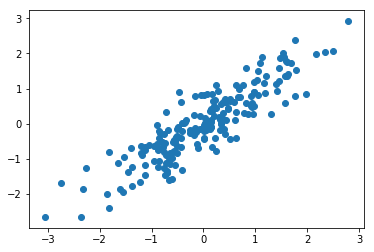

In [6]:
from sklearn.preprocessing import StandardScaler

sample = np.random.RandomState(1)
X = np.dot(sample.rand(2, 2), sample.randn(2, 200)).T
sc = StandardScaler()
X_std = sc.fit_transform(X)

print('相関係数{:.3f}:'.format(sp.stats.pearsonr(X_std[:, 0], X_std[:, 1])[0]))
plt.scatter(X_std[:, 0], X_std[:, 1])

#### 主成分分析の実行

主成分分析は`sklearn.decomposition`モジュールの`PCA`クラスを使うと実行できます。オブジェクトの初期化の際、変数を何次元まで圧縮したいか、つまり、抽出したい主成分の数を`n_components`として指定します。通常は元ある変数よりも小さい値を設定しますが、ここでは元データと同じ2と設定します。`fit`メソッドを実行することで、主成分の抽出に必要な情報が学習されます（具合的には、固有値と固有ベクトルが計算されます）。

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

#### 学習結果の確認
PCAオブジェクトの学習結果を確認しましょう。以下では、`components_`属性、`explained_variacne_`属性、`explained_variance_ratio_`属性を確認します。

##### ①components_属性
`components_`属性は固有ベクトルと呼ばれるもので、主成分分析により発見された新しい特徴空間の軸の向きを表し、結果は以下になります。ベクトルの[-0.707,-0.707]が第1主成分、[-0.707,0.707]が第2主成分の向きになります。

In [8]:
print(pca.components_)

[[-0.707 -0.707]
 [-0.707  0.707]]


#### ②explained_variance_属性

`explained_variance_`属性は各主成分の分散を表します。今回抽出された2つの主成分の分散が、それぞれ1.889と0.111であることがわかります。ここで分散の総和が2.0となるのは偶然ではなく、（標準化された）変数が元来有していた分散の総和と主成分の分散の総和は一致します。つまり、分散（情報）は維持されているということです。

In [9]:
print('各主成分の分散:{}'.format(pca.explained_variance_))

各主成分の分散:[1.899 0.111]


#### ③explained_variance_ratio_属性
`explained_variance_ratio_`属性は、各主成分が持つ分散の比率です。最初の0.945は1.889/(1.889+0.111)によって得られ、第1主成分で元のデータの94.5%の情報を保持していると読めます。

In [10]:
print('各主成分の分散割合:{}'.format(pca.explained_variance_ratio_))

各主成分の分散割合:[0.945 0.055]


数字だけではわかりにくいので図示してみましょう。以下の矢印が主成分分析によって得られた新しい特徴空間の軸の方向です。分散が最大の方向に第1主成分が定まり、第2主成分とのベクトルに対して、お互いに直交していることがわかります。ベクトルの[-0.707,-0.707]が第1主成分、[-0.707,0.707]が第2主成分の向きでしたので、それが以下のグラフからわかるとおもいます。

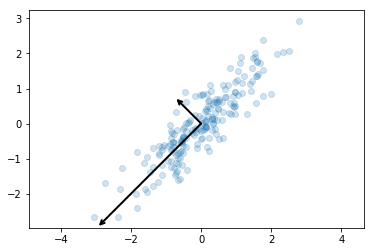

In [16]:
# パラメータ設定
arrowprops=dict(arrowstyle='->',
                linewidth=2,
                shrinkA=0, shrinkB=0)

# 矢印を描くための関数
def draw_vector(v0, v1):
    plt.gca().annotate('', v1, v0, arrowprops=arrowprops)

# 元のデータをプロット
plt.scatter(X_std[:, 0], X_std[:, 1], alpha=0.2)

# 主成分分析の2軸を矢印で表示する（なお、zip関数については、1章で学びました）
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)

plt.axis('equal');

>[参照URL]  

>https://github.com/jakevdp/PythonDataScienceHandbook

図を見て分かる通り、元の散布図に対して分散が最大になる方向で第1主成分です。そしてその次に分散が大きい方向が第2主成分です。第1主成分と第2主成分は直交します。

ここで元の値の各点から第1主成分に垂線を下ろした点を考えます。すると元々は2変数あった値を第1主成分の軸上にマッピングでき、1変数に次元削除できます。次のような図が参考になり、たとえば(x1,y1)の点は、a1だけになっています。

<img src="figures/chap12_01.png">

>[参照URL]  

>https://logics-of-blue.com/principal-components-analysis/

補足で、次元削減のイメージをもう少し理解するために、以下の例も見ておきましょう。以下は3Dで見たときのグラフで、プロット位置によって色を分けたものです。

![](https://sebastianraschka.com/images/blog/2014/kernel_pca/2014-09-14-kernel_pca_87_0.png)
参照URL:http://sebastianraschka.com/Articles/2014_kernel_pca.html

この3次元のデータを、主成分分析を使って2次元に落とすと以下のようになります。横軸PC1が第1主成分、縦軸PC2が第2主成分の値です。3次元の時のデータ構造が残されているだけではなく、元々あった位置も反映されていることが色の連なりからわかります。このように主成分分析は、元の情報を残しつつ次元を落とすという処理を行ってくれるのです。

![](https://sebastianraschka.com/images/blog/2014/kernel_pca/2014-09-14-kernel_pca_91_0.png)
参照URL:http://sebastianraschka.com/Articles/2014_kernel_pca.html

## 12.3.2　主成分分析の実例
主成分分析の実行方法と処理イメージについての説明は以上です。ではこの主成分分析を使って次元を圧縮することがどのような場面で役に立つのか、具体的に見ていきましょう。ここでは乳がんデータを使って、主成分分析の有用性を確認します。

乳がんデータは、sklearn.datasetsのload_breast_cancerに含まれています。load_breast_cancer()を実行すると、乳がんデータを読み込めます。以下に示すのは、実際に読み込んで、目的変数（cancer.target）の値が「malignant（悪性）」か「benign（良性）」によって、各説明変数の分布を可視化したものです。ほとんどのヒストグラムについて、malignantとbenignのデータが重なっており、このままだと悪性か良性かを見分けるためにどこに境界線を引いていいのかの判断は難しそうです。

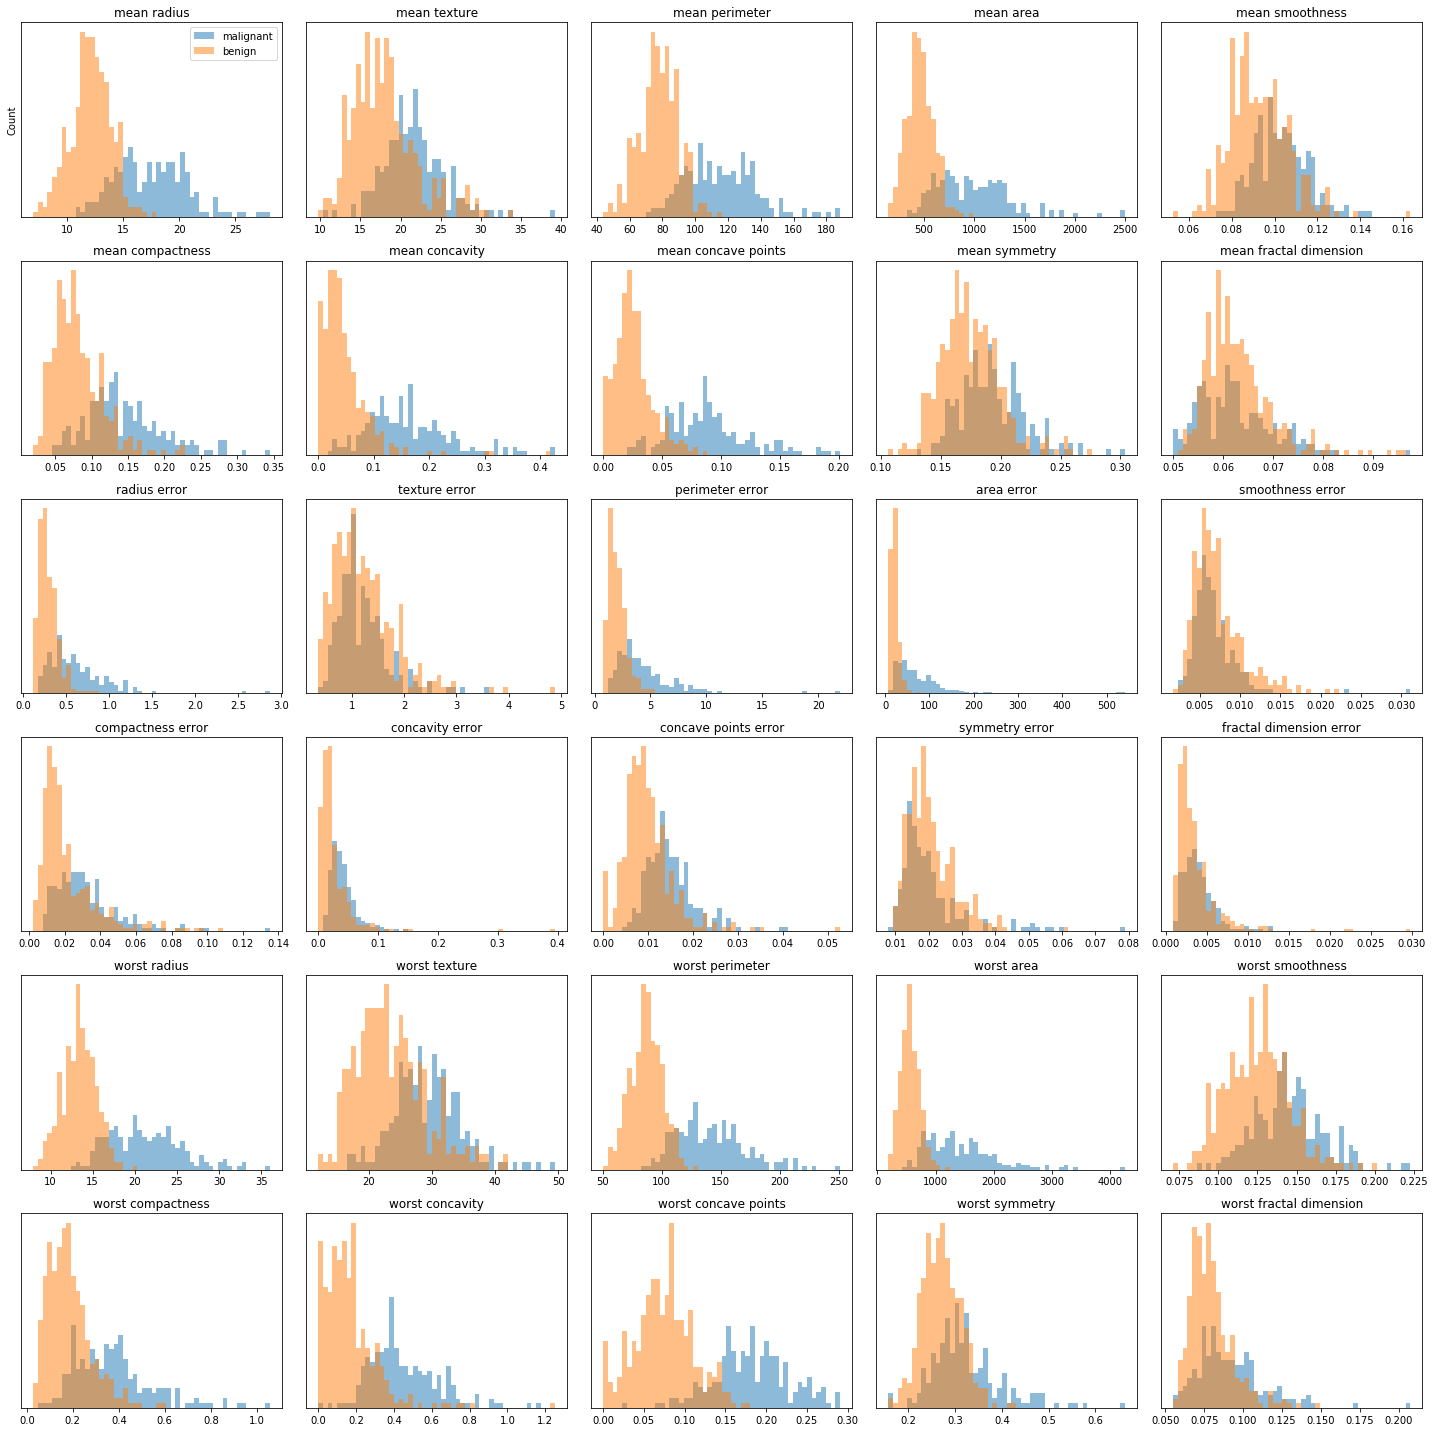

In [17]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
malignant = cancer.data[cancer.target==0]
benign = cancer.data[cancer.target==1]

fig, axes = plt.subplots(6,5,figsize=(20,20))
ax = axes.ravel()
for i in range(30):
    _,bins = np.histogram(cancer.data[:,i], bins=50)
    ax[i].hist(malignant[:,i], bins, alpha=.5)
    ax[i].hist(benign[:,i], bins, alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
    
# ラベルの設定
ax[0].set_ylabel('Count')
ax[0].legend(['malignant','benign'],loc='best')
fig.tight_layout()

>[参照文献]  

>『Introduction to Machine Learning with Python』（Andreas C.Muller & Sarah Guido、O'REILLY）

ここで主成分分析を使い、これら20以上ある変数の次元を削減してみます。具体的には、説明変数となるデータを対象にデータを標準化し、主成分分析を行います。抽出する主成分の数（n_component）は2とします。下記のプログラムを実行してexplained_variance_ratio_属性の値を確認すると、変数の数は2つに減るものの、元の情報の約63%（=0.443+0.19）が、第1主成分と第2主成分に凝縮されていることがわかります。

explained_variance_ratio_属性

In [21]:
sc = StandardScaler()
X_std = sc.fit_transform(cancer.data)

pca = PCA(n_components=2)
pca.fit(X_std)
X_pca = pca.transform(X_std)
print('X_pca shape:{}'.format(X_pca.shape))
print('Explained variance ratio:{}'.format(pca.explained_variance_ratio_))

X_pca shape:(569, 2)
Explained variance ratio:[0.443 0.19 ]


このように次元を低くしたデータを可視化してみます。まずは可視化準備のため、第1主成分と第2主成分のデータを説明変数に対応する目的変数を紐付け、良性データと悪性データに分離します。

In [24]:
X_pca = pd.DataFrame(X_pca, columns=['pc1','pc2'])
X_pca = pd.concat([X_pca, pd.DataFrame(cancer.target, columns=['target'])], axis=1)

# 悪性、良性を分ける
pca_malignant = X_pca[X_pca['target']==0]
pca_benign = X_pca[X_pca['target']==1]

さてこのデータをプロットしてみるとどうなるでしょうか。以下が結果です。malignant（悪性）を赤、benign（良性）を青でプロットしています。悪性と良性の境界線が見えると思います。

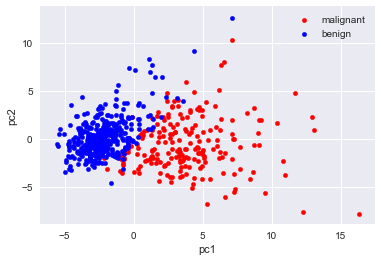

In [25]:
ax = pca_malignant.plot.scatter(x='pc1', y='pc2', color='red', label='malignant');
pca_benign.plot.scatter(x='pc1', y='pc2', color='blue', label='benign', ax=ax);
plt.grid(True)

このグラフを見る限り、本ケースにおいては、わずか2つの主成分で目的変数のクラスをほぼ分離できることがわかりました。変数が多くどの変数を分析に活用すべきかわからない場合などは、このように主成分分析を行い、(1)各主成分と目的変数の関係を明らかにする、(2)各主成分と元変数の関係から元変数と目的変数の関係を解釈する、などと進めるとデータ理解が進むでしょう。また主成分分析は、予測モデルを構築する際に変数の数を減らしたい場合（次元削減）にも活用できることを覚えておいてください（詳細は第13章で扱います）。最後に、各主成分と元々の説明変数の相関係数のことを因子負荷量（factor loading）と呼ぶことを覚えておきましょう。先述(2)の段階で一つの手段として活用するとよいでしょう。

####  <練習問題 1>
`sklearn.datasets`モジュールの`load_iris`関数を使ってアヤメのデータを読み込み、iris.dataを対象に主成分分析を行ってください。ただし、抽出する主成分の数は2とします。また、第2主成分までのデータと目的変数（iris.target）との関係性をグラフ化などし考察してください。

## 12.4 マーケットバスケット分析とアソシエーションルール
キーワード：アソシエーションルール、支持度、確信度、リフト値

本節では、教師なし学習の一つである**マーケットバスケット分析（Market Basket Analysis）**を学びます。

### 12.4.1　マーケットバスケット分析とは

マーケットバスケット分析とは、商品Aを購入するなら商品Bを購入するというように、商品購入の際の関連性を分析するものです。スーパーなどのレジを通過するバスケットを分析の基本単位としていたことから、このように呼ばれています。バスケット分析やアソシエーション分析とも呼ばれます。

マーケットバスケット分析の結果得られた、「商品Aを購入する人には商品Bも売れる」といった商品間の併売に関するルールのことを**アソシエーションルール（Association Rule）**と言います。よく取り上げられるルールに、ビールとオムツの例があります。オムツを買う父親にはビールを併売しやすいという話で、意外な組み合わせであったことから都市伝説的に語り継がれています。消費者に対して、どのような商品を併売しやすいかは、消費財メーカーや小売業において関心の高いテーマなので、アソシエーションルールの中でも有益なルールは、マーケティングキャンペーンの設計や推奨システムの中などで使われています。本節では、**支持度（support）**、**確信度（confidence）**、**リフト値（lift）**といった、アソシエーションルールの有益さを測る基礎的な指標を紹介します。


### 12.4.2　マーケットバスケット分析のためのサンプルデータを読み込む

以下では、第7章の総合問題でも扱った購買履歴データを使って、マーケットバスケット分析を具体的に説明していきます。
扱うデータは、以下URLからダウンロードできる`Online Retail.xlsx`というファイルです。購買履歴データはトランザクションデータ（※1）と言われるデータの一種です。そこでその略称のtransという変数名で読み込むことにします。head()を使って先頭の5レコードを表示したものが、下記の実行例です。

- http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx



※1：購買履歴データにおけるInvoiceNoは請求書番号のようなもので、同じInvoiceNoのものは1つの請求書に掲載された明細という意味です。つまり同じInvoiceNoの商品は、その取引でまとめて購入されたという意味になります。同じInvoiceNoのものの1セットが、1取引、すなわちトランザクションです。

In [26]:
trans = pd.read_excel('Online Retail.xlsx', sheet_name='Online Retail')
trans.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### データの整理と確認

この購買履歴データにおいて請求書番号を示す`IncoiceNo`の先頭の1文字は、そのトランザクションの状態を示しています。「5」が通常のデータ、「C」がキャンセル、「A」が不明なデータです。まずは次のように`InoivceNo`の先頭1文字を別の`cancel_flg`という変数として追加します。追加したら、それぞれのcancel_flgごとのレコード数を数えて集計します。実務において集計条件は、分析目的とデータマネジメント状態に大きく依存するので、十分に確認するようにしましょう。

In [27]:
trans['cancel_flg'] = trans.InvoiceNo.map(lambda x:str(x)[0])
trans.groupby('cancel_flg').size()

cancel_flg
5    532618
A         3
C      9288
dtype: int64

以下、通常のデータである「5」であり、かつ、CustomerIDが欠損していないデータだけを扱うことにします。これらのデータに絞り込むため、次のようにします。

In [28]:
trans = trans[(trans.cancel_flg == '5') & (trans.CustomerID.notnull())]

### 12.4.3　アソシエーションルール

データの準備ができたところで、アソシエーションルールについて説明します。
まずは、購買回数トップ5の製品番号を確認しておきましょう。製品番号はstockCodeです。Pandasの`Series`オブジェクトが持つ`value_counts`メソッドを使うと、それぞれの内容別のレコード件数がデフォルトでは降順で得られます。そこでheadを使って、上位5件を表示すると、次のようになります。

In [29]:
trans['StockCode'].value_counts().head(5)

85123A    2035
22423     1724
85099B    1618
84879     1408
47566     1397
Name: StockCode, dtype: int64

以下では上記のトップ5の商品のうち、第1位の85123Aと第3位の85099Bに関して、アソシエーションルールとその支持度、確信度、リフトについて説明していきます。

#### 支持度（support）

アソシエーションルールの支持度とは、ある商品（ここでは85123A）と別の商品（85099B）が併売されたバスケットの数（InvoiceNoの数）、または全体に占める割合です。以下で、商品85123Aを購入するなら商品85099Bする、というアソシエーションルールの支持度を計算します。

まず、トランザクション（1つの取引。同一のInvoiceNoを持つ1セット）に登場する全てのバスケットの数をカウントします。ここでは、すべてのInvoiceNoをtrans_allとして抽出します。集合型とすることで、InvoiceNoを重複ない状態で保持できます。
次に両商品を含むバスケットをtrans_abとして抽出します。そのためには、各々の商品を含むInvoiceNoを同様に抽出し（下記ではtrans_aならびにtrans_b）、それらの積集合をとります。

In [30]:
trans_all = set(trans.InvoiceNo) 
trans_a = set(trans[trans['StockCode']=='85123A'].InvoiceNo)
trans_b = set(trans[trans['StockCode']=='85099B'].InvoiceNo)
trans_ab = trans_a&trans_b

ルールの支持度は、ルールに含まれる両商品を含むバスケットの数または全体に占める割合です。そこで、次のようにして計算できます。

In [31]:
print('support#:{}'.format(len(trans_ab)))
print('support%:{:.3f}'.format(len(trans_ab)/len(trans_all)))

support#:252
support%:0.014


一般的に支持度の小さいルールは有用性も低いことが多いことから、支持度は足切り基準として使われたりします。また支持度はルールの支持度だけではなく、ルールを構成する商品に対する支持度を計算することもあります。たとえば商品85123Aの支持度は、以下のように計算できます。ルールの支持度が必要なのか、ルールを構成する商品の支持度が必要なのか、分析目的を明確にした上で求めるようにしましょう。

In [32]:
print('商品85123Aのsupport#:{}'.format(len(trans_a)))
print('商品85123Aのsupport%:{:.3f}'.format(len(trans_a)/len(trans_all)))

商品85123Aのsupport#:1978
商品85123Aのsupport%:0.107


#### 確信度（confidence）

確信度とは、ある商品Aのトランザクション数をベースに、その商品Aとある商品Bの組み合わせ購買がどれくらいの割合であるのかを表します。商品85123Aを購入するなら商品85099Bする、というルールの確信度は、次のように計算できます。

In [33]:
print('confidence:{:.3f}'.format(len(trans_ab)/len(trans_a)))

confidence:0.127


逆に、商品85099Bを購入するなら商品85123Aする、というルールの確信度は以下のようになります。

In [34]:
print('confidence:{:.3f}'.format(len(trans_ab)/len(trans_b)))

confidence:0.158


確信度が高いと商品間の併売が見込めるため、クロスセル（他の商品などを併せて購入してもらうこと）をさせたい場合は確信度の高い商品の中からオファー商品を決定するなどの場面で活用されます。ただし、確信度の絶対値だけでは併売傾向の判断を誤ることがあるため、次のリフト値も合わせて見るのが普通です。

#### リフト値（lift）

商品Aを購入するなら商品Bを購入するというアソシエーションルールにおいて、そのリフトとは、ルールの確信度(%)を商品Bの支持度(%)で割った値のことです。つまり、全体のバスケットに占める商品Bの購買率に対する、商品Aを購買したときの商品Bの購買率の比率がリフト値です。当然、リフト値が1.0よりも大きければ併売しやすい商品になりますし、1.0よりも小さければ併売しにくい商品と解釈できます。商品85123Aを購入するなら商品85099Bする、というルールのリフトは以下のように求められます。

In [35]:
support_b = len(trans_b) / len(trans_all)
confidence = len(trans_ab) / len(trans_a)
lift = confidence / support_b
print('lift:{:.3f}'.format(lift))

lift:1.476


確信度が高い数値でもリフト値が1.0を下回る場合は、顧客への商品推奨の根拠としては不適切かもしれません。分析の目的に照らし、確信度とリフト値を組み合わせて使うなどしましょう。

以上で、バスケット分析についての説明を終えます。今回は集計対象となったデータ全体に対してアソシエーションルールを抽出しましたが、店舗エリア別、店舗タイプ別、顧客クラスター別などにルールを抽出すると、より有用性の高いルールが抽出できるかもしれないことを覚えておきましょう。

>[参考文献]

>『最強のデータ分析組織 なぜ大阪ガスは成功したのか』(河本 薫 (著)、日経BP社)

>『最強のビッグデータ戦略』（ビル・フランクス (著), 長尾高弘  (翻訳)、日経BP社）

>『データサイエンティストの秘密ノート 35の失敗事例と克服法』（高橋 威知郎  (著), 白石 卓也 (著), 清水 景絵 (著)、SBクリエイティブ）

>『アクセンチュアのプロフェッショナルが教える データ・アナリティクス実践講座』（アクセンチュア アナリティクス (著), 工藤 卓哉  (監修), 保科 学世 (監修)、翔泳社 ）


>『機械脳の時代―――データサイエンスは戦略・組織・仕事をどう変えるのか?』(加藤 エルテス 聡志 (著)、ダイヤモンド社)

>『会社を変える分析の力 (講談社現代新書) 』(河本 薫 (著)、講談社)

####  <練習問題 1>
本節で用いた購買履歴データを使って、その他、任意の商品の組み合わせについて、支持度、確信度、リフト値を算出してみましょう。

## 12.5 総合問題

### 12.5.2 総合問題1
12.4節で用いた購買履歴データを使って、どの商品とどの商品の組み合わせの支持度が一番高いですか？ただし、レコード数が1000より多い商品（StockCode）を対象に計算してください。（ヒント：商品の組み合わせを抽出するときは、itertoolsモジュールが便利です。）